# MLops project - Lung segmentation - 01 training

Autoencoders can also be trained for image segmentation. Segmentation means separating specific objects in the image from the background. In practice, this usually comes down to coloring the relevant object in the image. Image segmentation finds its application in self-driving cars, video surveillance and medical imaging. The goal of this assignment is to segment lungs from X-ray images.


Pictures of the lungs can be found in the 'Lung_images' folder.

In this case, the labels are mask images indicating the exact location of the lungs in the image. These masks can be found in the 'Lung_masks' folder.


- Read the images and resize them to the same dimension. For example to 400x400 pixels. A lower resolution is also allowed if you notice that the system requirements are not sufficient. For this application you can convert the images to grayscale.

- Create a training set and test set. Put 20 images in the test set.

- Train a convolutional autoencoder on the training set. The output layer must have the same dimension as the mask images. The autoencoder is then trained to generate a mask based on a long scan that approximates the ground truth mask as closely as possible. However we'll need to use a custom loss function. In fact, cross-entropy based loss functions are not always the best option. In practice, the dice coefficient loss is often used. This loss function looks at the overlap between two data samples. In this case how much the mask generated by the autoencoder overlaps with the ground truth mask. You have to pass this dice loss as a custom loss fuction to the neural network.

```Python
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2.*intersection + smooth)/(K.sum(K.square(y_true),-1)+ K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

```  

Test the auto encoder on the test set. Visualize the generated mask and compare with the actual mask. Try to improve the segmentation via hyperparameter tuning. Use the dice coefficient as a metric in addition to visual inspection.

 U-net is a widely used neural network for medical image segmentation. An implementation can be found here: https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277. Implement, train and test this network. Also use the dice coefficient loss as the (custom) loss function. Discuss the results.
 

### Import packages

Import Python packages you need in this session. Also display the Azure Machine Learning SDK version.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import azureml.core
from azureml.core import Workspace

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.34.0


### Connect to workspace

Create a workspace object from the existing workspace. `Workspace.from_config()` reads the file **config.json** and loads the details into an object named `ws`.

In [2]:
# load workspace configuration from the config.json file in the current folder.
ws = Workspace.from_config()
print(ws.name, ws.location, ws.resource_group, sep='\t')

mlopslungs	westeurope	mlops-home-grp_8


### Create experiment

Create an experiment to track the runs in your workspace. A workspace can have muliple experiments. 

In [3]:
experiment_name = 'mlops-lung-segmentation'

from azureml.core import Experiment
exp = Experiment(workspace=ws, name=experiment_name)

### Create or Attach existing compute resource

> Note that if you have an AzureML Data Scientist role, you will not have permission to create compute resources. Talk to your workspace or IT admin to create the compute targets described in this section, if they do not already exist.

By using Azure Machine Learning Compute, a managed service, data scientists can train machine learning models on clusters of Azure virtual machines. Examples include VMs with GPU support. In this tutorial, you create Azure Machine Learning Compute as your training environment. You will submit Python code to run on this VM later in the tutorial. 
The code below creates the compute clusters for you if they don't already exist in your workspace.

**Creation of compute takes approximately 5 minutes.** If the AmlCompute with that name is already in your workspace the code will skip the creation process.

In [4]:
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget
import os

# choose a name for your cluster
compute_name = os.environ.get("AML_COMPUTE_CLUSTER_NAME", "cpu-cluster2")
compute_min_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MIN_NODES", 0)
compute_max_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MAX_NODES", 4)

# This example uses CPU VM. For using GPU VM, set SKU to STANDARD_NC6
vm_size = os.environ.get("AML_COMPUTE_CLUSTER_SKU", "STANDARD_D2_V2")


if compute_name in ws.compute_targets:
    compute_target = ws.compute_targets[compute_name]
    if compute_target and type(compute_target) is AmlCompute:
        print("found compute target: " + compute_name)
else:
    print("creating new compute target...")
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = vm_size,
                                                                min_nodes = compute_min_nodes, 
                                                                max_nodes = compute_max_nodes)

    # create the cluster
    compute_target = ComputeTarget.create(ws, compute_name, provisioning_config)
    
    # can poll for a minimum number of nodes and for a specific timeout. 
    # if no min node count is provided it will use the scale settings for the cluster
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)
    
     # For a more detailed view of current AmlCompute status, use get_status()
    print(compute_target.get_status().serialize())

found compute target: cpu-cluster2


### Reading dataset

In [5]:
# azureml-core of version 1.0.72 or higher is required
from azureml.core import Workspace, Dataset

dataset_folder = os.path.join(os.getcwd(), "dataset")
os.makedirs(dataset_folder, exist_ok=True)

subscription_id = '31701647-d61e-4ee8-a1ae-e4fc5d71e6f6'
resource_group = 'MLOps-Home-Grp_8'
workspace_name = 'mlopslungs'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='lungs')
dataset.download(target_path=dataset_folder, overwrite=True)

['/mnt/batch/tasks/shared/LS_root/mounts/clusters/lungs/code/Users/brecht.willems2/dataset/Lung_images/CHNCXR_0001_0.png',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/lungs/code/Users/brecht.willems2/dataset/Lung_images/CHNCXR_0002_0.png',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/lungs/code/Users/brecht.willems2/dataset/Lung_images/CHNCXR_0003_0.png',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/lungs/code/Users/brecht.willems2/dataset/Lung_images/CHNCXR_0004_0.png',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/lungs/code/Users/brecht.willems2/dataset/Lung_images/CHNCXR_0005_0.png',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/lungs/code/Users/brecht.willems2/dataset/Lung_images/CHNCXR_0006_0.png',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/lungs/code/Users/brecht.willems2/dataset/Lung_images/CHNCXR_0007_0.png',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/lungs/code/Users/brecht.willems2/dataset/Lung_images/CHNCXR_0008_0.png',
 '/mnt/batch/tas

In [5]:
import cv2 
import os 
import glob 
import random

Lung_images_path = glob.glob("./dataset/Lung_images/*.png*") 
Lung_masks_path = glob.glob("./dataset/Lung_masks/*.png*") 

def read_images(path):
    images = []
    for f in path: 
        img = cv2.imread(f) 
        im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(im_rgb, (400,400))
        images.append(resize) 
    return images

X = np.array(read_images(Lung_images_path)) # images
y = np.array(read_images(Lung_masks_path)) # masks

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=20, random_state=42)

print(X_train.shape)
print(X_test.shape)

(684, 400, 400)
(20, 400, 400)


In [7]:
# normalisatie van de pixel waarden
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
y_train = y_train.astype('float32') / 255
y_test = y_test.astype('float32') / 255

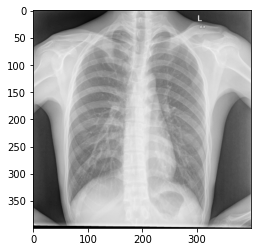

In [8]:
# plotting images
plt.figure()
plt.imshow(X_train[0], cmap="gray")
plt.show()

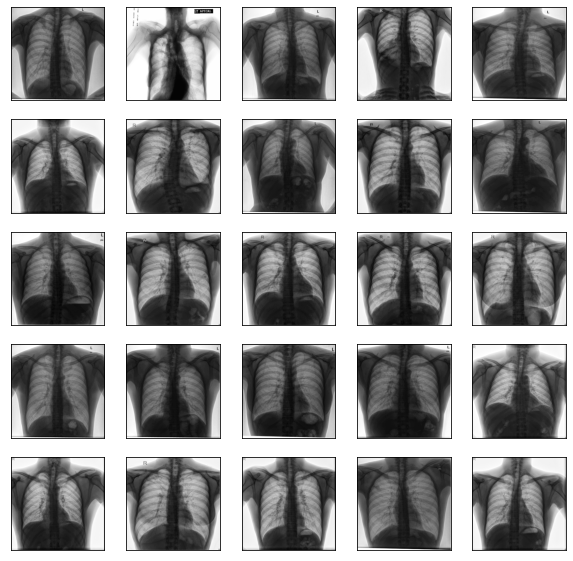

In [9]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
plt.show()

## Train on a remote cluster

For this task, you submit the job to run on the remote training cluster you set up earlier.  To submit a job you:
* Create a directory
* Create a training script
* Create a script run configuration
* Submit the job 

### Create a directory

Create a directory to deliver the necessary code from your computer to the remote resource.

In [10]:
import os
script_folder = os.path.join(os.getcwd(), "mlops-lung-segmentation-training")
os.makedirs(script_folder, exist_ok=True)

### Create and train autoencoder manual

In [11]:
import numpy as np
import pandas as pd
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf

from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

latent_dim = 64 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(400*400, activation='sigmoid'),
      layers.Reshape((400, 400))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

  def dice_coef(self, y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2.*intersection + smooth)/(K.sum(K.square(y_true),-1)+ K.sum(K.square(y_pred),-1) + smooth)

  def dice_coef_loss(self, y_true, y_pred):
    return 1-self.dice_coef(y_true, y_pred)

autoencoder = Autoencoder(latent_dim)

2021-12-01 21:32:07.056642: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2021-12-01 21:32:07.057446: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-12-01 21:32:17.232399: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-12-01 21:32:17.708893: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-12-01 21:32:17.708947: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lungs): /proc/driver/nvidia/version does not exist
2021-12-01 21:32:17.711647: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimi

In [12]:
epochs = 20
batchsize = 64

autoencoder.compile(optimizer='adam', loss=autoencoder.dice_coef_loss)
autoencoder.fit(X_train, y_train, epochs=epochs, batch_size=batchsize, shuffle=True)

2021-12-01 21:32:17.995640: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 437760000 exceeds 10% of free system memory.
2021-12-01 21:32:19.713025: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 437760000 exceeds 10% of free system memory.
2021-12-01 21:32:23.316273: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 40960000 exceeds 10% of free system memory.
2021-12-01 21:32:23.438876: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 40960000 exceeds 10% of free system memory.
2021-12-01 21:32:23.499828: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 40960000 exceeds 10% of free system memory.


Epoch 1/20
11/11 [==============================] - 5s 417ms/step - loss: 0.4834
Epoch 2/20
11/11 [==============================] - 5s 431ms/step - loss: 0.3663
Epoch 3/20
11/11 [==============================] - 5s 432ms/step - loss: 0.3583
Epoch 4/20
11/11 [==============================] - 5s 433ms/step - loss: 0.3527
Epoch 5/20
11/11 [==============================] - 5s 410ms/step - loss: 0.3465
Epoch 6/20
11/11 [==============================] - 5s 430ms/step - loss: 0.3377
Epoch 7/20
11/11 [==============================] - 5s 425ms/step - loss: 0.3146
Epoch 8/20
11/11 [================

In [13]:
encoded_imgs = autoencoder.encoder(X_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

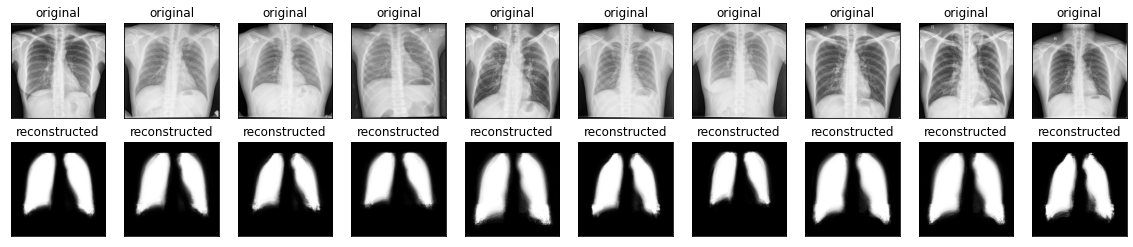

In [14]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(X_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

### Create a training script

To submit the job to the cluster, first create a training script. Run the following code to create the training script called `train.py` in the directory you just created. 

In [15]:
%%writefile $script_folder/train.py

import argparse
import os
import numpy as np
import glob
import cv2 
import random
import joblib
import pandas as pd
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
import onnxmltools
import tf2onnx
from sklearn.model_selection import train_test_split

from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

from azureml.core import Workspace, Dataset, Run

# argumenten
parser = argparse.ArgumentParser()
parser.add_argument('--modelname', type=str, dest='modelname', default="model1")
parser.add_argument('--modelversion', type=float, dest='modelversion', default=0.1)
parser.add_argument('--epochs', type=int, dest='epochs', default=20)
parser.add_argument('--batchsize', type=int, dest='batchsize', default=64)
args = parser.parse_args()

# data inlezen
dataset_folder = os.path.join(os.getcwd(), "dataset")
os.makedirs(dataset_folder, exist_ok=True)

run = Run.get_context()
workspace = run.experiment.workspace

dataset = Dataset.get_by_name(workspace, name='lungs')
dataset.download(target_path=dataset_folder, overwrite=True)

# reading images
Lung_images_path = glob.glob("./dataset/Lung_images/*.png*") 
Lung_masks_path = glob.glob("./dataset/Lung_masks/*.png*") 

def read_images(path):
    images = []
    for f in path: 
        img = cv2.imread(f) 
        im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(im_rgb, (400,400))
        images.append(resize) 
    return images

X = np.array(read_images(Lung_images_path)) # images
y = np.array(read_images(Lung_masks_path)) # masks

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=20, random_state=42)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, sep = '\n')

# normalisatie van de pixel waarden
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
y_train = y_train.astype('float32') / 255
y_test = y_test.astype('float32') / 255

# Creating autoencoder model
latent_dim = 64 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(400*400, activation='sigmoid'),
      layers.Reshape((400, 400))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

  def dice_coef(self, y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2.*intersection + smooth)/(K.sum(K.square(y_true),-1)+ K.sum(K.square(y_pred),-1) + smooth)

  def dice_coef_loss(self, y_true, y_pred):
    return 1-self.dice_coef(y_true, y_pred)

autoencoder = Autoencoder(latent_dim)

autoencoder.compile(optimizer='adam', loss=autoencoder.dice_coef_loss)
history = autoencoder.fit(X_train, y_train, epochs=args.epochs, batch_size=args.batchsize, shuffle=True)

print("Train an autoencoder with batchsize {}; epochs: {}".format(args.batchsize, args.epochs))

# Showing loss
print("loss training: {}".format(history.history['loss']))

# adding logs
run.log('batch size', np.int(args.batchsize))
run.log('epochs', np.int(args.epochs))

os.makedirs('outputs', exist_ok=True)
onnx_model = onnxmltools.convert_keras(autoencoder) 
onnxmltools.utils.save_model(onnx_model, 'outputs/keras_example.onnx')

# autoencoder.save("outputs/{}.{}".format(args.modelname, args.modelversion))

Writing /mnt/batch/tasks/shared/LS_root/mounts/clusters/lungs/code/Users/brecht.willems2/mlops-lung-segmentation-training/train.py


### Configure the training job

Create a ScriptRunConfig object to specify the configuration details of your training job, including your training script, environment to use, and the compute target to run on. Configure the ScriptRunConfig by specifying:

* The directory that contains your scripts. All the files in this directory are uploaded into the cluster nodes for execution. 
* The compute target.  In this case you will use the AmlCompute you created
* The training script name, train.py
* An environment that contains the libraries needed to run the script
* Arguments required from the training script. 

In this tutorial, the target is AmlCompute. All files in the script folder are uploaded into the cluster nodes for execution. The data_folder is set to use the dataset.

First, create the environment that contains: the scikit-learn library, azureml-dataset-runtime required for accessing the dataset, and azureml-defaults which contains the dependencies for logging metrics. The azureml-defaults also contains the dependencies required for deploying the model as a web service later in the part 2 of the tutorial.

Once the environment is defined, register it with the Workspace to re-use it in part 2 of the tutorial.

In [16]:
from azureml.core.environment import Environment
from azureml.core.conda_dependencies import CondaDependencies

# to install required packages
env = Environment('lungs-env')
env.docker.enabled = True
dockerfile = r"""
FROM mcr.microsoft.com/azureml/base:intelmpi2018.3-ubuntu16.04
RUN apt-get update && apt-get install -y libgl1-mesa-glx
RUN echo "Hello from custom container!"
"""
env.docker.base_image = None
env.docker.base_dockerfile = dockerfile

cd = CondaDependencies.create(pip_packages=['azureml-dataset-runtime[pandas,fuse]', 'azureml-defaults', 'opencv-python', 'azure-ml-api-sdk', 'onnxmltools', 'onnxruntime', 'tf2onnx'], conda_packages = ['scikit-learn==0.22.1', 'tensorflow', "pillow"])

env.python.conda_dependencies = cd

# Register environment to re-use later
env.register(workspace = ws)

'enabled' is deprecated. Please use the azureml.core.runconfig.DockerConfiguration object with the 'use_docker' param instead.


{
    "databricks": {
        "eggLibraries": [],
        "jarLibraries": [],
        "mavenLibraries": [],
        "pypiLibraries": [],
        "rcranLibraries": []
    },
    "docker": {
        "arguments": [],
        "baseDockerfile": "\nFROM mcr.microsoft.com/azureml/base:intelmpi2018.3-ubuntu16.04\nRUN apt-get update && apt-get install -y libgl1-mesa-glx\nRUN echo \"Hello from custom container!\"\n",
        "baseImage": null,
        "baseImageRegistry": {
            "address": null,
            "password": null,
            "registryIdentity": null,
            "username": null
        },
        "enabled": true,
        "platform": {
            "architecture": "amd64",
            "os": "Linux"
        },
        "sharedVolumes": true,
        "shmSize": null
    },
    "environmentVariables": {
        "EXAMPLE_ENV_VAR": "EXAMPLE_VALUE"
    },
    "inferencingStackVersion": null,
    "name": "lungs-env",
    "python": {
        "baseCondaEnvironment": null,
        "condaD

In [17]:
from azureml.core import ScriptRunConfig

args = ['--modelname', "lung_autoencoder", '--modelversion', 0.1, '--epochs', 30, '--batchsize', 64]

src = ScriptRunConfig(source_directory=script_folder,
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

### Submit the job to the cluster

Run the experiment by submitting the ScriptRunConfig object. And you can navigate to Azure portal to monitor the run.

In [18]:
run = exp.submit(config=src)
run

Experiment,Id,Type,Status,Details Page,Docs Page
mlops-lung-segmentation,mlops-lung-segmentation_1638394451_d3519468,azureml.scriptrun,Starting,Link to Azure Machine Learning studio,Link to Documentation


In [19]:
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

### Get log results upon completion

Model training happens in the background. You can use `wait_for_completion` to block and wait until the model has completed training before running more code. 

In [20]:
# specify show_output to True for a verbose log
run.wait_for_completion(show_output=True) 

RunId: mlops-lung-segmentation_1638394451_d3519468
Web View: https://ml.azure.com/runs/mlops-lung-segmentation_1638394451_d3519468?wsid=/subscriptions/31701647-d61e-4ee8-a1ae-e4fc5d71e6f6/resourcegroups/mlops-home-grp_8/workspaces/mlopslungs&tid=4ded4bb1-6bff-42b3-aed7-6a36a503bf7a

Execution Summary
RunId: mlops-lung-segmentation_1638394451_d3519468
Web View: https://ml.azure.com/runs/mlops-lung-segmentation_1638394451_d3519468?wsid=/subscriptions/31701647-d61e-4ee8-a1ae-e4fc5d71e6f6/resourcegroups/mlops-home-grp_8/workspaces/mlopslungs&tid=4ded4bb1-6bff-42b3-aed7-6a36a503bf7a

Warnings:
This run might be using a new job runtime with improved performance and error reporting. The logs from your script are in user_logs/std_log.txt. Please let us know if you run into any issues, and if you would like to opt-out, please add the environment variable AZUREML_COMPUTE_USE_COMMON_RUNTIME to the environment variables section of the job and set its value to the string "false"




{'runId': 'mlops-lung-segmentation_1638394451_d3519468',
 'target': 'cpu-cluster2',
 'status': 'Completed',
 'startTimeUtc': '2021-12-01T21:34:29.604574Z',
 'endTimeUtc': '2021-12-01T21:36:27.235268Z',
 'services': {},
 'warnings': [{'message': 'This run might be using a new job runtime with improved performance and error reporting. The logs from your script are in user_logs/std_log.txt. Please let us know if you run into any issues, and if you would like to opt-out, please add the environment variable AZUREML_COMPUTE_USE_COMMON_RUNTIME to the environment variables section of the job and set its value to the string "false"'}],
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': 'bf0d4a22-726e-4e16-ac47-f8411e22039f',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': '64324a05-75e2-43cb-86f7-f5150a4e7ba6'}, 'consumptionDetails': {'type': 'Reference'}}],
 

### Display run results

You now have a model trained on a remote cluster.  Retrieve all the metrics logged during the run, including the accuracy of the model:

In [24]:
print(run.get_metrics())

{'batch size': 64, 'epochs': 30}


## Register model


In [25]:
print(run.get_file_names())

['logs/azureml/17_azureml.log', 'logs/azureml/dataprep/backgroundProcess.log', 'logs/azureml/dataprep/backgroundProcess_Telemetry.log', 'logs/azureml/dataprep/rslex.log', 'outputs/keras_example.onnx', 'system_logs/cs_capability/cs-capability.log', 'system_logs/hosttools_capability/hosttools-capability.log', 'system_logs/lifecycler/execution-wrapper.log', 'system_logs/lifecycler/lifecycler.log', 'system_logs/lifecycler/vm-bootstrapper.log', 'user_logs/std_log.txt']


In [27]:
# register model 

#run.register_model(model_name='lungs_autoencoder', model_path='outputs/lung_autoencoder.0.1')
run.register_model(model_name='lungs_autoencoder', model_path='outputs/keras_example.onnx')


Model(workspace=Workspace.create(name='mlopslungs', subscription_id='31701647-d61e-4ee8-a1ae-e4fc5d71e6f6', resource_group='mlops-home-grp_8'), name=lungs_autoencoder, id=lungs_autoencoder:6, version=6, tags={}, properties={})